<a href="https://colab.research.google.com/github/raphillipson/RecurrenceAnalysis/blob/master/Recurrence_Plot_Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**A quick overview of recurrence analysis.**

A **recurrence plot (RP)** is the visualization of a square matrix. Each non-zero entry of the matrix (i,j) corresponds to two positions in time in which a dynamical state recurs. Specifically, the states that correspond to the two points in time ($x_i$ and $x_j$ from the time series) are positions that are "close" to each other when the time series is projected into phase space. The closeness of these two positions is determined by a threshold neighborhood size: the distance between $x_i$ and $x_j$ must be less than the size of the neighborhood, $\epsilon$. A value of '1' in the matrix indicates these two positions are within an $\epsilon$ distance, and a value of '0' indicates they are not. The resulting matrix is thus binary.

Mathematically, the recurrence matrix is defined as:

$R_{i,j}(\epsilon) = \Theta(\epsilon−||x_i−x_j||)$ for $i,j= 1,...,N$

where $\Theta$ is the Heaviside function.

Here is an example recurrence plot of a sine wave (source: https://doi.org/10.1371/journal.pone.0187049.g002):

![](RP_sine.png)

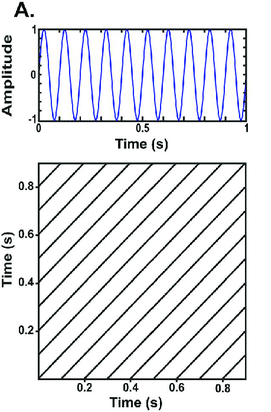

In [ ]:
from IPython.display import Image
Image("RP_sine.png")

The recurrence plot is symmetric about the main diagonal (from bottom left to upper right). The diagonal lines are vertically spaced by the period of the sine wave. This, and other types of structure, can be quantified. One can imagine that the introduction of noise might chop up the diagonal lines that we see. We will explore various ways to quantify structure and account for noise below.

### **How to get a time series into phase space?**

A scalar (1D) time series can be cast into phase space using the Takens' **Time Delay Embedding** technique. This involves selecting an appropriate 'time delay' and embedding dimension. For example, if we want to make a two-dimensional embedding of a time series $u(t)$, the coordinates (x,y) of a position in the 2D phase space corresponds to $x = u_i$ (the position i in the time series) and $y = u_i - \tau$ (the position $i + \tau$ in the time series). If we add a third dimension to phase space, then $z = u_i - 2\tau$, and so on (dimensions can surpass 3; there is no actual upper limit).

We must make appropriate choices of the time delay and the embedding dimension in order for the phase space embedding to properly contain the same dynamical information as the underlying system that generates the time series. Put another way, if we want to be able to isolate specific trajectories, or states, in phase space, then we must have a high enough dimension such that these trajectories do not cross. This is equivalent to ensuring that we have unique solutions to a differential equation, where a solution is represented by a specific trajectory and is unique if it never intersects another.

Typically, the autocorrelation time or first minimum of the mutual information are acceptable estimates for the time delay -- that is, when the coordinates making up a position in phase space are not correlated in time to one another in the original time series. For the embedding dimension, the 'false nearest neighbors' algorithm is appropriate. This involves systematically increasing the embedding dimension and when neighboring positions in phase space are no longer moving away from each other with increasing dimension (e.g. less than 10% 'false neighbors'), we have reached an appropriate embedding dimension.






**Some References**

*   For an extensive overview of RPs, see Marwan et al. 2007 (DOI:10.1016/j.physrep.2006.11.001) or this useful website: http://www.recurrence-plot.tk

*   Time Delay Method and Embeddings: Sauer et al. 1991 (DOI:10.1007/BF01053745) or this useful website: http://www.scholarpedia.org/article/Attractor_reconstruction

*   False Nearest Neighbors: Kennel et al. 1992 (https://journals.aps.org/pra/abstract/10.1103/PhysRevA.45.3403)
*   Mutual Information: Fraser & Swinney 1986 (https://journals.aps.org/pra/abstract/10.1103/PhysRevA.33.1134)

### **Example Recurrence Plots**
Let's start with a sine wave.

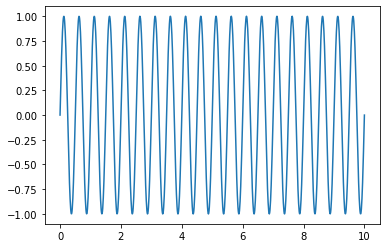

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fs = 100    # (integer) sampling rate
f = 2       # (integer) fundamental frequency of the sinusoid
t = 10      # (integer) duration of the time series

time = np.linspace(0, t, t * fs) 
signal = np.sin(2 * np.pi * f * time) # for sin(B*t) the period is 2*pi/B

plt.plot(time, signal)

Now, let's determine the appropriate embedding parameters to cast this time series in phase space using the time delay method.

First, let's just play with two dimensions and explore the time delay. What happens if we project the sinusoid into phase space using a time delay of 1 (here we mean, off-set by one position in the numpy array - which corresponds to one times the cadence).


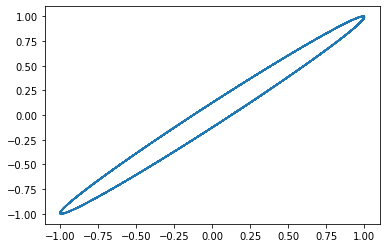

In [ ]:
tau = 1  # (integer) delay in # of *indices*
signal_delayed = signal[tau:]

plt.plot(signal[:-tau], signal_delayed)

We get a curve that approaches straight line because the points are highly correlated - the time delay is not big enough to trace out the differential information of a sinusoid. We can actually take a hint from what we know about the derivative of sine (cosine). At what phase shift does cosine begin to look like sine?

tau (in indices): 12
tau (in generic time units): 0.12


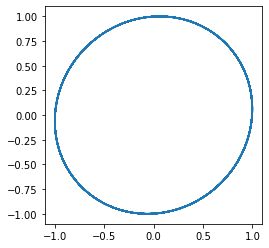

In [ ]:
# This is the period of the sine wave * sampling rate, to get the index in the time series corresponding to 1 period
#    divide by 4 for the phase shift when sine = cosine(shift) (i.e. pi/2)
tau = int(1.0/f * fs / 4.0)  
print("tau (in indices):", tau)
print("tau (in generic time units): %0.2f" %(tau/fs) )

signal_delayed = signal[tau:]


fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(signal[:-tau], signal_delayed)
ax.set_aspect('equal')

# For funsies, try a divisor other than 4, to explore the shape in phase space (e.g. 3 or 5)

When we use pi/2, we achieve the maximally-unfolded-in-phase-space time delay embedding in two dimensions for sine. Now let's see if we can recover the same time delay from the first zero of the autocorrelation function.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


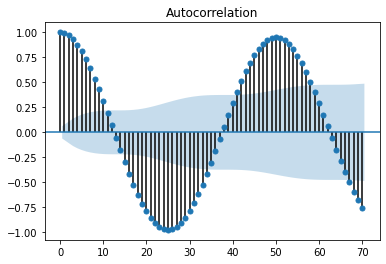

In [ ]:
# grab a simple autocorrelation function plotting from statsmodels
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(signal, lags=70)
plt.show()

The first zero occurs between 10 and 15 (the x axis is in *indices*, not time), which is the index corresponding to pi/4, the same we figured out by eye from looking at the phase space.

*Note*: the first minimum of the mutual information (MI) is generally preferred, especially if specifically searching for nonlinearity. MI is akin to the ACF, but also including nonlinear correlations. If a signal has no zero-crossing, or the first minimum is unclear, then the autocorrelation time should be used (the time for 1/e decay of the ACF).

Now let's look at the recurrence plot using the time delay corresponding to pi/2 and play with the embedding dimension.
First, a couple definitions:
 
*   The "recurrence rate" (RR) is the ratio of the number of entries in the recurrence matrix with values of 1 to the total number of possible entries (size of the matrix). In general, we should consider low values of the recurrence rate (e.g. under 25 percent or so), but this can depend on the structures we are looking for. We want the corresponding threshold (the value that determines whether two points are "close" to each other) to RR to be *larger* than the error of the measurements. 
*   The "metric" refers to how the distance between two points in phase space is computed. Here we use the standard 'euclidean' metric.



In [ ]:
# We will use the package PyUnicorn, which contains recurrence plots and recurrence networks functionality
# http://www.pik-potsdam.de/~donges/pyunicorn/

!pip install -q pyunicorn


     |████████████████████████████████| 890kB 2.7MB/s 
     |████████████████████████████████| 3.2MB 17.5MB/s 


**NOTE: This is really annoying, but when you execute the next cell, you will get an error message about "import _ _ version _ _" not working. You can just click the link to the file ( _ _ init _ _.py) and line in question (should be line 43) and comment it out with no impact, then re-run.**

pyunicorn: Package netCDF4 could not be loaded. Some functionality in class Data might not be available!
pyunicorn: Package netCDF4 could not be loaded. Some functionality in class NetCDFDictionary might not be available!
Calculating recurrence plot at fixed recurrence rate...
Calculating the euclidean distance matrix...
Recurrence rate: 0.14999631201953811
Determinism: 0.9999999999999312


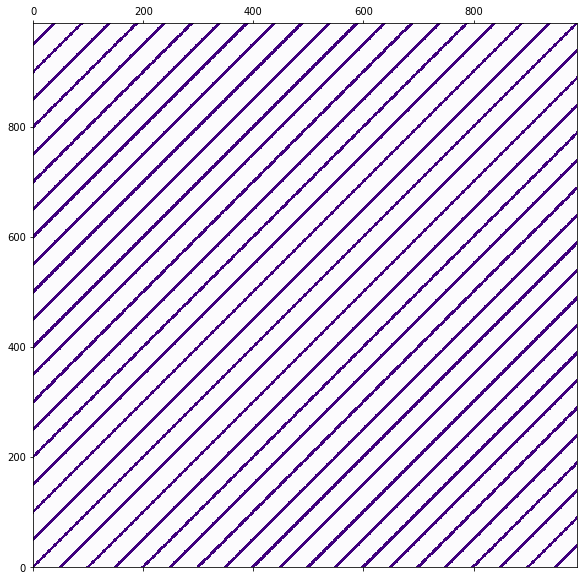

In [ ]:
from pyunicorn.timeseries import RecurrencePlot

#  Generate a recurrence plot object with fixed recurrence rate RR
DIM = 2  # start with dimension 2 (like the phase space portrait we plotted above)
TAU = 12 # this is always in indices; 
         # for the parameters we used, this corresponds to pi/2, or the first zero-crossing in the ACF

rp = RecurrencePlot(signal, dim=DIM, tau=TAU, metric='euclidean',
                    normalize=False, recurrence_rate=0.15)

rp_matrix = rp.recurrence_matrix()
np.savetxt("sine_recurrence_matrix.dat", rp_matrix)

# There are a variety of quantities we can immediately extract from the RP:
RR = rp.recurrence_rate()
print("Recurrence rate:", RR)

# The Determinism (DET) is the fraction of recurrence (non-zero) points in the RP that are part of lines
#   of lengths at least 2 relative to the total size of the RP -- this traces the diagonal structure
#   in the RP. For increasing number of random, isolated points in the RP, this value decreases. If every point
#   in the RP is part of a diagonal line, then we have a purely deterministic signal (e.g. a sine wave!)
#   and the DET is 1
DET = rp.determinism()
print("Determinism:", DET)

#  Show the recurrence plot in pretty purple
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(rp.recurrence_matrix(), cmap='Purples')

# Standard practice is to have the time axes increasing upwards/rightwards
ax.grid(False)
ax.invert_yaxis()

plt.savefig("sine_recurrence_plot.png")
plt.show()

You'll notice that changing the embedding dimension for the above sine wave gives us the same recurrence plot so long as it is at least 2 dimensions. In order to obtain a **complete** dynamical picture of a sinusoid, the Takens' time delay method necessitates that the embedding dimension be at least twice the theoretical dimension. The *surface* that is traced out in phase space is 1D for a simple pendulum (i.e. a circle; there is only one degree of freedom; the box-counting dimension is 1). Therefore, to properly embed that geometric object, we require an embedding dimension of at least 2.

Once we have a high enough dimension, that value and any higher will provide a dynamically accurate depiction of the underlying system. It becomes less useful to use an unnecessarily high dimension, as we typically are dealing with finite time series, but the point is that there is only a *lower limit* to the embedding dimension.

### **What happens when we add noise?!?!111?!?!!**

We've been dealing with the simplest, most classic vanilla version of a time series. Let's explore what happens when we add simple white noise.

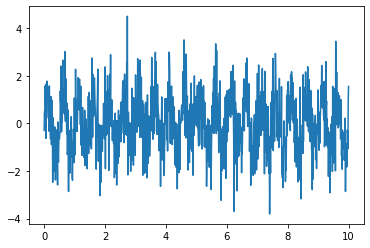

In [ ]:
# Let's go back to our friend and shake him up a bit

fs = 100    # (integer) sampling rate
f = 2       # (integer) fundamental frequency of the sinusoid
t = 10      # (integer) duration of the time series

time = np.linspace(0, t, t * fs) 
so_pure_signal = np.sin(2 * np.pi * f * time) # for sin(B*t) the period is 2*pi/B
noise = np.random.normal(0,1,len(so_pure_signal))
noisy_signal = so_pure_signal + noise

plt.plot(time, noisy_signal)


Calculating recurrence plot at fixed recurrence rate...
Calculating the euclidean distance matrix...
Recurrence rate: 0.14999823458795283
Determinism: 0.3283898305084502


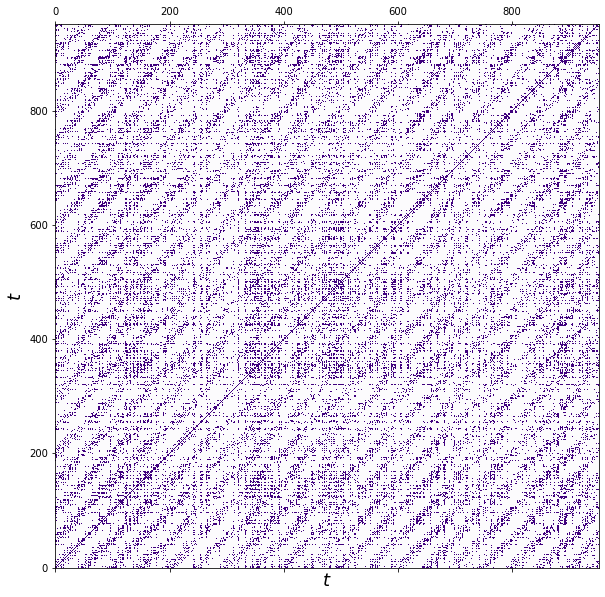

In [ ]:
from pyunicorn.timeseries import RecurrencePlot

#  Generate a recurrence plot object with fixed recurrence rate RR
DIM = 5
TAU = 12 

rp = RecurrencePlot(noisy_signal, dim=DIM, tau=TAU, metric='euclidean',
                    normalize=False, recurrence_rate=0.15)

rp_matrix = rp.recurrence_matrix()
np.savetxt("noisy_sine_recurrence_matrix.dat", rp_matrix)

RR = rp.recurrence_rate()
print("Recurrence rate:", RR)

DET = rp.determinism()
print("Determinism:", DET)

#  Show the recurrence plot in pretty purple
f, ax1  = plt.subplots(1, 1, figsize=(10,10))
ax1.matshow(rp.recurrence_matrix(), cmap='Purples')
ax1.invert_yaxis()
ax1.set_ylabel(r"$t$", fontsize=18)
ax1.set_xlabel(r"$t$", fontsize=18)
plt.show()


This recurrence plot no longer has the beautifully uninterrupted lines. Saaaaad. 

How might we be able to pull out the dynamical information (the sine wave) from the noise? 
To start - let's try messing with the embedding dimension and see at what point the periodic signal becomes more obvious. Qualitatively, this might be almost immediately as we increase from 2 to 3, and on, dimensions.

So, how do we determine a proper embedding dimension?
* We can determine the proper embedding dimension by eye, assuming we know a bit about the dynamics (in this case, the period). 
* If we know nothing about the signal, then we should use the false nearest neighbors algorithm.

In [ ]:
# Some simple functions for nonlinear time series analysis developed by M. Mannattil et al.
!pip install -q git+https://github.com/manu-mannattil/nolitsa.git


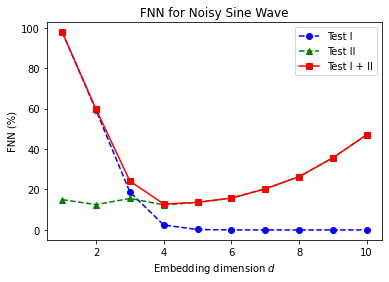

In [ ]:
from nolitsa import data, dimension

# Implements the false nearest neighbors (FNN) method described by
# Kennel et al. (1992) to calculate the minimum embedding dimension
# required to embed a scalar time series.

# For Test I (f1): we want the dimension for which the test returns 0 (or close to it)
# For Test II (f2): this is heavily influenced by the chosen distance metric; 
#                   we want the dimension that coresponds to a minimum in this measure
# f1+f2 is the combination of Test I and Test II

# the range of dimensions we want to test
dim = np.arange(1, 10 + 1)

# be sure to use the proper time delay
# window = Theiler window: this should be at least the autocorrelation time (it's the corridor along the main diagonal line of the RP)
f1, f2, f3 = dimension.fnn(noisy_signal, tau=tau, dim=dim, window=tau)

plt.title(r'FNN for Noisy Sine Wave')
plt.xlabel(r'Embedding dimension $d$')
plt.ylabel(r'FNN (%)')
plt.plot(dim, 100 * f1, 'bo--', label=r'Test I')
plt.plot(dim, 100 * f2, 'g^--', label=r'Test II')
plt.plot(dim, 100 * f3, 'rs-', label=r'Test I + II')
plt.legend()

plt.show()



Typically, the first test is the most commonly used practice of FNN; the second test is influenced by the distance metric used. Here we see that an embedding dimension of 4 or 5 is the optimal value satisfying both tests.

So, now that we've covered 'optimal' embeddings, I can introduce the caveat that for the determination of dynamical invariants (things like dimension, correlation entropy and other similar topological measures), the embedding parameters don't actually have a serious impact (e.g., https://aip.scitation.org/doi/10.1063/1.1667633).



We can readily see this when we look at the **"Close Returns" of the recurrence plot**. Close returns are merely individual diagonal lines in the recurrence plot (regions that are 'close' to repeating themselves), which probes of the 'unstable periodic orbits'. Many dynamical measures, such as the natural measure, Lyapunov exponents, fractal dimensions, and entropy can be expressed in terms of a sum over the unstable periodic orbits. 

The **close returns histogram ($H(\tau)$)** is the summation of all of these diagonal features as a function of distance from the main diagonal of the recurrence plot, otherwise known as the 'delay' or 'offset' (usually referred to as $\tau$, but confusingly, this is distinct from the time delay of the embedding parameters).

*Handy ref: http://www.scholarpedia.org/article/Unstable_periodic_orbits*

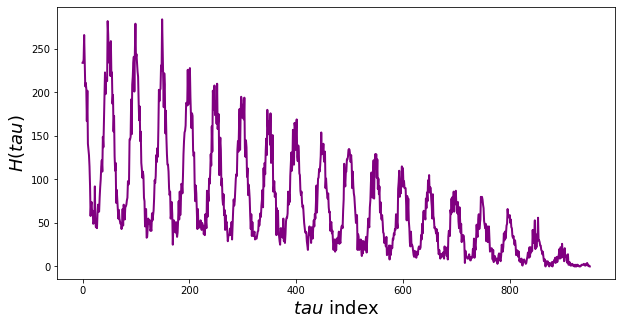

In [ ]:
# Compute "close returns" :
#   sum up the recurrence points in each diagonal in the matrix = histogram of recurrences as a function of delay
rp_matrix = np.loadtxt("noisy_sine_recurrence_matrix.dat")
close_returns = [np.sum(np.diagonal(rp_matrix, offset=row)) for row in range(1, len(rp_matrix[0]))]
x = np.arange(0,len(close_returns),1)

# Plot close returns; time axis is as a function of offset from the main diagonal of the recurrence plot 
f, ax2  = plt.subplots(1, 1, figsize=(10,5))
ax2.plot(x, close_returns, color="purple", linestyle='-', alpha=1.0, linewidth=2)
ax2.set_xlabel(r"$tau$ index", fontsize=18)
ax2.set_ylabel(r"$H(tau)$", fontsize=18)
plt.show()

If you spend time changing the embedding dimension you'll see that the close returns histogram displays clear peaks about multiples of the primary period of the sine wave, despite the presence of noise in the recurrence plot itself. The optimal embedding dimension improves the distinction of the dynamical system above the added noise by eliminating those false neighbors that arise due to the randomness in the signal. The close returns histogram becomes a sensitive probe of dynamical information despite the presence of such noise.

## Distinguishing noise from signal in real data